There is something funny about my tides compared to NOAA tides. What is it?

To calculate my tides, I used the NOAA harmonic constituents published on this website:

https://tidesandcurrents.noaa.gov/harcon.html?unit=0&timezone=1&id=9443090&name=Neah+Bay&state=WA

I sent these constituents into t_tide to generate a tidal prediction from 2015-2020 but I removed the long period constituents like Sa, Ssa, etc. When I loaded the constituents into t_tide I had to change some of the names because of convention mismatches between t_tide and NOAA. I matched the NOAA name with the t_tide name by compariing phase speeds. This affected RHO, LAM2, 2MK3, M1, all or wich have amplitudes < 2 cm.

BUT, I matched M1 to NO1. The problem is that NO1 has different nodal factors than M1. M1 nodal factors can actually be quite large (like 2!) so I think this is a problem.

I also use tides calculated directly by NOAA, donwloaded off their website: 
https://tidesandcurrents.noaa.gov/waterlevels.html?id=9443090

I also calculated tides using constituents from a t_tide harmonic analysis.

In [1]:
import netCDF4 as nc

import matplotlib.pyplot as plt

from nowcast import analyze, residuals, figures
from nowcast.workers import get_NeahBay_ssh
import datetime
import numpy as np
from dateutil import tz
import seaborn as sns
import pandas as pd

%matplotlib inline

### Load all of the tides

1. my tides - using NOAA constituents but remove long period. Also messed up by replacing M1 with NO1.
2. NOAA tides - pull NOAA tides from their website.
3. ttide - contituents from ttide harmonic analysis removing long period.

In [2]:
sdt = datetime.datetime(2015,8,1,tzinfo=tz.tzutc())
edt = datetime.datetime(2015,10,31,tzinfo=tz.tzutc())

tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/tidal_predictions/'

my_tides = figures.get_tides('Neah Bay', path=tides_path)
NOAA_tides = figures.get_NOAA_tides(figures.SITES['Neah Bay']['stn_no'],
                                    sdt.strftime('%d-%b-%Y'),edt.strftime('%d-%b-%Y'), interval='h')
ttide = figures.get_tides('Neah Bay',
                          path='/data/nsoontie/MEOPAR/analysis/storm_surges/data/')

obs = figures.get_NOAA_wlevels(figures.SITES['Neah Bay']['stn_no'],
                                    sdt.strftime('%d-%b-%Y'),edt.strftime('%d-%b-%Y'), product='hourly_height')

### Calculate residuals

In [3]:
obs_interp = figures.interp_to_model_time(my_tides.time, obs.wlev, obs.time)
NOAA_interp = figures.interp_to_model_time(my_tides.time, NOAA_tides.pred, NOAA_tides.time)
ttide_interp = figures.interp_to_model_time(my_tides.time, ttide.pred_all, ttide.time)

my_res = obs_interp - my_tides.pred_all
NOAA_res = np.array(obs_interp) - np.array(NOAA_interp)
ttide_res = np.array(obs_interp) - np.array(ttide_interp)

### Plot residuals

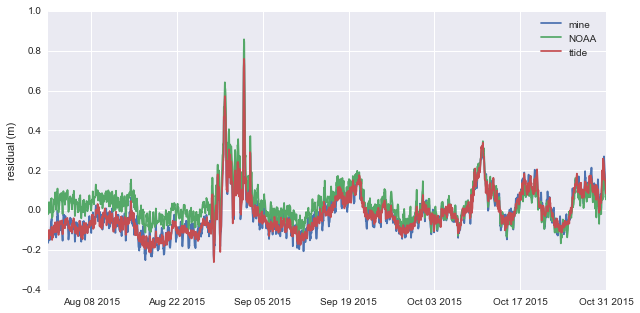

In [4]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
for res, label in zip([my_res, NOAA_res, ttide_res ], ['mine', 'NOAA', 'ttide']):
    ax.plot(my_tides.time, res, label=label)
ax.set_xlim([sdt, edt])
ax.legend(loc=0)
ax.set_ylabel('residual (m)')

### Power spectrum

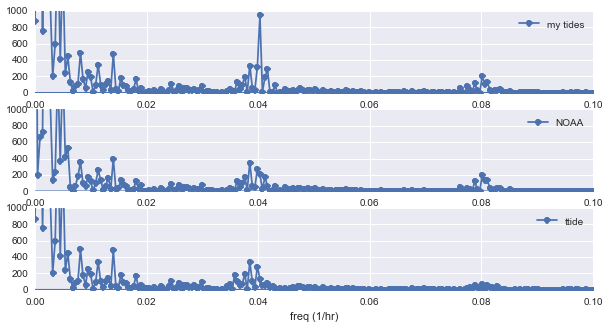

In [5]:
fig,axs=plt.subplots(3,1, figsize=(10,5))
for ar, label, ax in zip([my_res, NOAA_res, ttide_res ], ['my tides', 'NOAA', 'ttide'], axs):
    tmp_array =np.array(ar)
    tmp = tmp_array[~np.isnan(tmp_array)]
    ps = np.abs(np.fft.fft((tmp)))**2
    freqs = np.fft.fftfreq(tmp.size, 1)
    ax.plot(freqs,ps,'o-',label=label)
    ax.set_ylim([0,10**3])
    ax.set_xlim([0,.1])
    ax.set_xlabel('freq (1/hr)')
    ax.legend(loc=0)

In [6]:
1/24

0.041666666666666664

In [7]:
1/12

0.08333333333333333

* t_tide does the best at removing the diurnal and semi-diurnal signal from the residual.
* my_tides has energy at both diurnal and semi-diurnal. I think the diurnal can be explained by using NO1 instead of M1. 
* NOAA has energy at the semidirunal so I'm not surprised that my tides does too. 

### Look at forecasted residuals with different tides

In [8]:
numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]
for_mine = np.array([])
for_time_mine = np.array([])
for date in dates:
    filename_NB, run_date = analyze.create_path('forecast', date, 'ssh*.txt')
    times_NB, surge_NB, _ = residuals.NeahBay_forcing_anom(
        filename_NB, run_date,tides_path)
    surge_NB_trun, time_NB_trun = analyze.truncate_data(np.array(surge_NB), np.array(times_NB),
                                                                 date, date + datetime.timedelta(days=1))
    for_mine = np.append(for_mine,surge_NB_trun); 
    for_time_mine= np.append(for_time_mine, time_NB_trun)

tides_mine_interp = figures.interp_to_model_time(for_time_mine, my_tides.pred_all, my_tides.time)
tides_NOAA_interp = figures.interp_to_model_time(for_time_mine, NOAA_tides.pred, NOAA_tides.time) 
tides_ttide_interp = figures.interp_to_model_time(for_time_mine, ttide.pred_all, ttide.time) 

for_NOAA = for_mine + tides_mine_interp - tides_NOAA_interp
for_ttide = for_mine + tides_mine_interp - tides_ttide_interp


### Plot forecasted residual

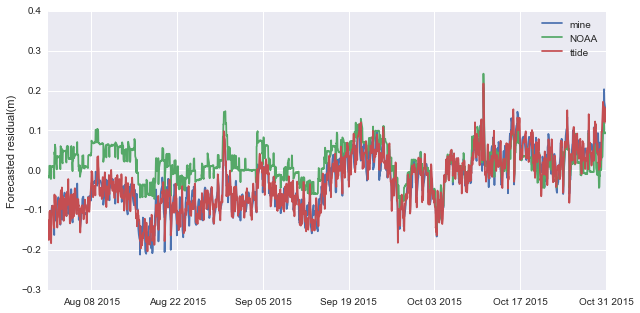

In [9]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
for res, label in zip([for_mine, for_NOAA, for_ttide ], ['mine', 'NOAA', 'ttide']):
    ax.plot(for_time_mine, res, label=label)
ax.set_xlim([sdt, edt])
ax.legend(loc=0)
ax.set_ylabel('Forecasted residual(m)')

* Not super enlightening, but there is a fairly regular flattening of the NOAA calculated resiudals every day. We can see this flattening in their website plots too. I think their forecast becomes less accurate into the future. 
* What does the flattening mean it I switch over to using ttide tides? There will be times when we get a small spike in the residual when NOAA would predict a flat residual. Is the amplitde large enough for us to worry?

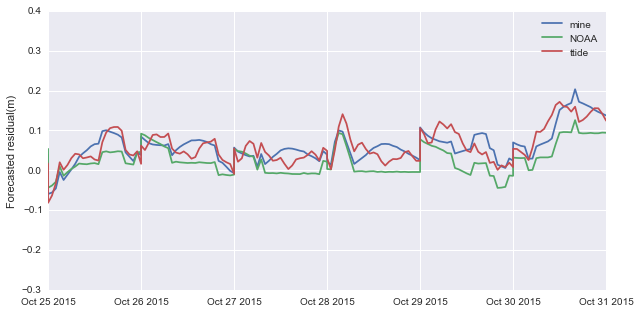

In [10]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
for res, label in zip([for_mine, for_NOAA, for_ttide ], ['mine', 'NOAA', 'ttide']):
    ax.plot(for_time_mine, res, label=label)
ax.set_xlim([datetime.datetime(2015,10,25), datetime.datetime(2015,10,31)])
ax.legend(loc=0)
ax.set_ylabel('Forecasted residual(m)')

### Scatter plot


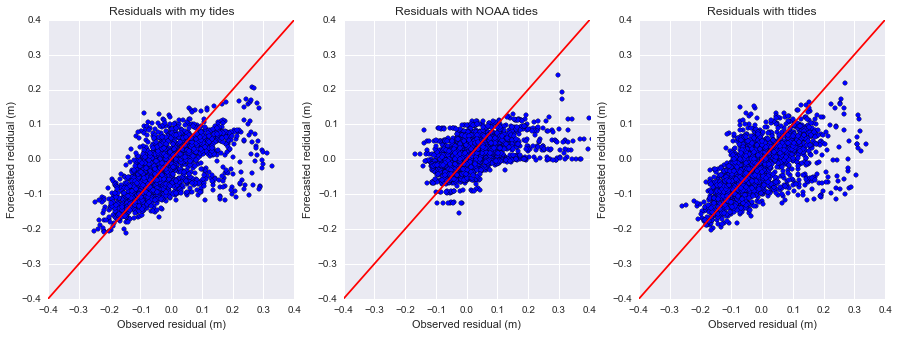

In [13]:
obs = [my_res, NOAA_res, ttide_res]
forecasts = [for_mine, for_NOAA, for_ttide]
titles = ['my tides', 'NOAA tides', 'ttides']

fig, axs = plt.subplots(1,3,figsize=(15,5))
for  o, f, title, ax in zip(obs, forecasts, titles, axs):
    res_trun, time_trun = analyze.truncate_data(np.array(o), np.array(my_tides.time), sdt, edt)
    for_trun = figures.interp_to_model_time(time_trun, f, for_time_mine)
    ax.scatter(res_trun, for_trun)
    ax.plot([-.4,.4], [-.4,.4],'r-')
    ax.set_xlim([-.4,.4])
    ax.set_ylim([-.4,.4])
    ax.set_xlabel('Observed residual (m)')
    ax.set_ylabel('Forecasted redidual (m)')
    ax.set_title('Residuals with {}'.format(title))